Using device: cuda
dat shape (neurons × trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance

Training SAE...
Epoch  10/60 | loss=0.000948
Epoch  20/60 | loss=0.001288
Epoch  30/60 | loss=0.000709
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000559
Epoch  60/60 | loss=0.000550
SAE latent: (4500, 100) (1400, 100)

Model-selection summary:
selection
INCONCL    388
SAE         88
PCA         24
Name: count, dtype: int64

Significant neurons after FDR=0.05: 41 / 500


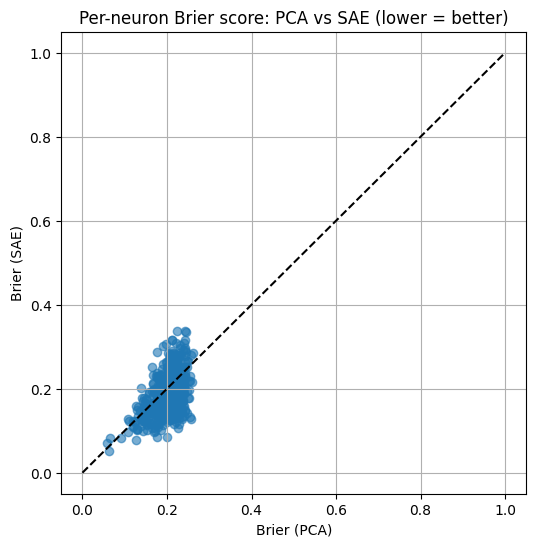

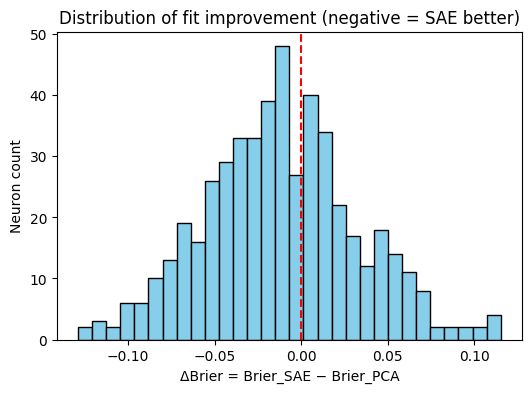


Top neurons preferring SAE:
     neuron_idx  Brier_PCA  Brier_SAE  delta_Brier   boot_lo   boot_hi  \
242       15035   0.255795   0.126960    -0.128834 -0.191528 -0.066220   
132       17961   0.255473   0.132465    -0.123009 -0.176518 -0.060250   
116       32521   0.225880   0.105918    -0.119961 -0.165436 -0.068493   
337       37777   0.200140   0.084359    -0.115782 -0.154425 -0.074726   
482        3569   0.229057   0.116024    -0.113032 -0.162378 -0.063445   
236       29982   0.236045   0.128465    -0.107581 -0.154157 -0.063222   
321       32397   0.247759   0.143069    -0.104690 -0.149353 -0.053714   
469       18975   0.240245   0.136134    -0.104111 -0.156967 -0.047747   
74        36559   0.234959   0.132335    -0.102623 -0.160925 -0.033452   
154       29999   0.221940   0.119638    -0.102303 -0.155861 -0.046319   

        p_adj  
242  0.022716  
132  0.022716  
116  0.022716  
337  0.022716  
482  0.022716  
236  0.022716  
321  0.022716  
469  0.041646  
74   0.04164

In [1]:
# ================================================================
#  Per-Neuron Model Selection: PCA vs SAE (Brier-score criterion)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skbio.stats.composition import clr
from scipy.special import softmax
from statsmodels.stats.multitest import multipletests
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Helper: Brier utilities
# ---------------------------------------------------------------
def brier_score(y_mean, p_mean):
    """Compute mean squared difference between predicted and observed means."""
    return float(np.mean((p_mean - y_mean) ** 2))

def paired_boot_ci_delta_brier(y_mean, p_pca, p_sae, B=2000, seed=0):
    """Bootstrap CI for delta_Brier = Brier(SAE) - Brier(PCA)."""
    rng = np.random.default_rng(seed)
    n = len(y_mean)
    idx = np.arange(n)
    deltas = []
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        b_p = brier_score(y_mean[samp], p_pca[samp])
        b_s = brier_score(y_mean[samp], p_sae[samp])
        deltas.append(b_s - b_p)
    deltas = np.array(deltas)
    return (
        float(np.mean(deltas)),
        float(np.quantile(deltas, 0.025)),
        float(np.quantile(deltas, 0.975)),
    )

def paired_perm_p_delta_brier(y_mean, p_pca, p_sae, R=2000, seed=0):
    """Permutation test for delta_Brier < 0 (SAE better if negative)."""
    rng = np.random.default_rng(seed)
    obs = brier_score(y_mean, p_sae) - brier_score(y_mean, p_pca)
    n = len(y_mean)
    count = 0
    for _ in range(R):
        mask = rng.random(n) < 0.5
        p1 = np.where(mask, p_sae, p_pca)
        p2 = np.where(mask, p_pca, p_sae)
        stat = brier_score(y_mean, p1) - brier_score(y_mean, p2)
        if stat <= obs:  # SAE better => smaller Brier
            count += 1
    pval = (count + 1) / (R + 1)
    return float(obs), float(pval)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)
test_img_ids = np.repeat(np.arange(n_images), n_trials)[test_mask]

# ---------------------------------------------------------------
#  Transform
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  PCA Features
# ================================================================
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} comps explain ≥90% variance")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# ================================================================
#  SAE on PCA features
# ================================================================
SAE_DIM = 100
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(),
            nn.Linear(500, d_latent), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS,
              batch=SAE_BATCH, lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE...")
sae_model, sae_scaler = train_sae(X_train_pca)
Z_train = encode(sae_model, sae_scaler, X_train_pca)
Z_test  = encode(sae_model, sae_scaler, X_test_pca)
print("SAE latent:", Z_train.shape, Z_test.shape)

# ================================================================
#  Logistic + Brier per neuron
# ================================================================
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    y_train, y_test = y[train_mask], y[test_mask]

    # --- PCA model ---
    log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_pca.fit(X_train_pca, y_train)
    except Exception:
        continue
    y_prob_pca = log_pca.predict_proba(X_test_pca)[:, 1]

    # --- SAE model ---
    log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_sae.fit(Z_train, y_train)
    except Exception:
        continue
    y_prob_sae = log_sae.predict_proba(Z_test)[:, 1]

    # --- aggregate by image ---
    dfp = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_pca})
    dfs = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_sae})
    agg_p = dfp.groupby("img").agg(y_mean=("y", "mean"), p_mean=("p", "mean"))
    agg_s = dfs.groupby("img").agg(y_mean=("y", "mean"), p_mean=("p", "mean"))

    y_img = agg_p["y_mean"].to_numpy()
    p_img_pca = agg_p["p_mean"].to_numpy()
    p_img_sae = agg_s["p_mean"].to_numpy()

    brier_p = brier_score(y_img, p_img_pca)
    brier_s = brier_score(y_img, p_img_sae)
    delta_mean, lo, hi = paired_boot_ci_delta_brier(y_img, p_img_pca, p_img_sae, B=1000, seed=idx)
    obs, p_perm = paired_perm_p_delta_brier(y_img, p_img_pca, p_img_sae, R=2000, seed=idx)
    select = "SAE" if hi < 0 else ("PCA" if lo > 0 else "INCONCL")

    results.append({
        "neuron_idx": idx,
        "Brier_PCA": brier_p, "Brier_SAE": brier_s,
        "delta_Brier": obs,
        "boot_mean": delta_mean, "boot_lo": lo, "boot_hi": hi,
        "p_perm": p_perm, "selection": select
    })

df = pd.DataFrame(results)
reject, pvals_corrected, _, _ = multipletests(df["p_perm"], alpha=0.05, method="fdr_bh")
df["p_adj"], df["significant"] = pvals_corrected, reject

print("\nModel-selection summary:")
print(df["selection"].value_counts())
print(f"\nSignificant neurons after FDR=0.05: {df['significant'].sum()} / {len(df)}")

# ================================================================
#  Visualization
# ================================================================
plt.figure(figsize=(6,6))
plt.scatter(df["Brier_PCA"], df["Brier_SAE"], alpha=0.6)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Brier (PCA)")
plt.ylabel("Brier (SAE)")
plt.title("Per-neuron Brier score: PCA vs SAE (lower = better)")
plt.grid(True)
plt.show()

# ΔBrier histogram
plt.figure(figsize=(6,4))
plt.hist(df["delta_Brier"], bins=30, color="skyblue", edgecolor="k")
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("ΔBrier = Brier_SAE − Brier_PCA")
plt.ylabel("Neuron count")
plt.title("Distribution of fit improvement (negative = SAE better)")
plt.show()

# Top improved neurons
print("\nTop neurons preferring SAE:")
print(df.sort_values("delta_Brier", ascending=True)
      .head(10)[["neuron_idx","Brier_PCA","Brier_SAE","delta_Brier","boot_lo","boot_hi","p_adj"]])


In [2]:
np.sqrt(0.12)

np.float64(0.34641016151377546)

Using device: cuda
dat shape (neurons x trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance.


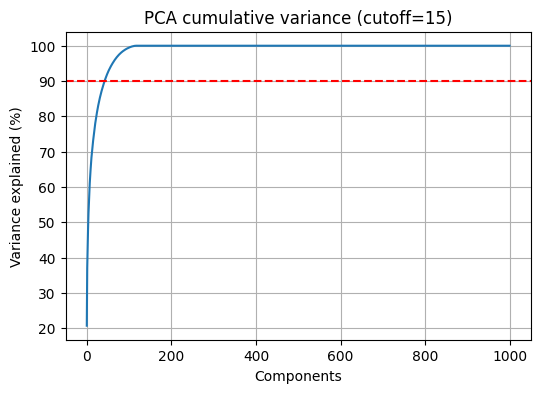


Training SAE on PCA features (all images)...
Epoch  10/60 | loss=0.000961
Epoch  20/60 | loss=0.000877
Epoch  30/60 | loss=0.000738
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000586
Epoch  60/60 | loss=0.000779
SAE latent shape: (5900, 100)

=== 5-Fold Crossvalidated Brier Scores (Held-out Images) ===
   neuron_idx  Brier_PCA_mean  Brier_PCA_std  Brier_SAE_mean  Brier_SAE_std  \
0       24711          0.1922         0.0433          0.1938         0.0636   
1       28019          0.1982         0.0344          0.1880         0.0485   
2       17490          0.2270         0.0340          0.1962         0.0671   
3        7070          0.1847         0.0274          0.1803         0.0469   
4        3454          0.2159         0.0297          0.2402         0.0678   
5        7681          0.2177         0.0326          0.2235         0.0852   
6       27409          0.2160         0.0535          0.2122         0.0692   
7       21177          0.2216         0.0284          0.

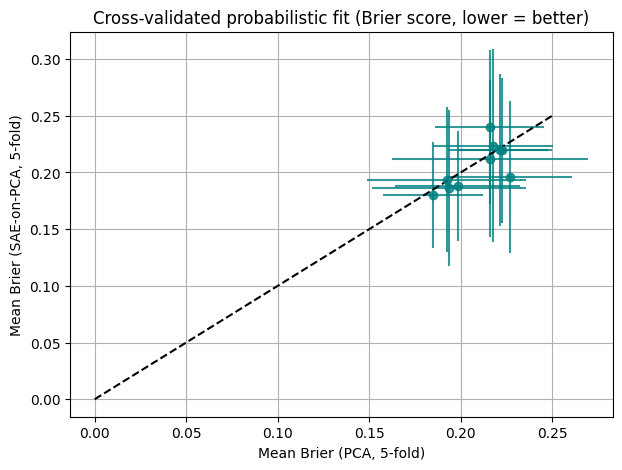

In [3]:
# ================================================================
#   5-FOLD CV: Verify SAE-vs-PCA effect on top SAE-preferring neurons (Brier)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, warnings, torch, torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax
from skbio.stats.composition import clr
from torch.utils.data import DataLoader, TensorDataset
from sklearn.exceptions import ConvergenceWarning

# ---------------------------------------------------------------
# Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Brier helper
# ---------------------------------------------------------------
def compute_brier(y_true, y_pred, img_ids):
    """Collapse by image and compute Brier score."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    return np.mean((agg["p"] - agg["y"]) ** 2)

# ================================================================
# Load data
# ================================================================
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # (118, 1000)
Y_binary = (dat > 0).astype(int)

n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
assert n_samples == n_images * n_trials
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# CLR transform and PCA
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

pca_full = PCA()
pca_full.fit(X_trials_clr)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
n_components_90 = 15  # fixed for comparability
print(f"PCA: {n_components_90} comps explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
X_pca_full = pca.fit_transform(X_trials_clr)

plt.figure(figsize=(6,4))
plt.plot(cum_var * 100)
plt.axhline(90, color='r', linestyle='--')
plt.title(f'PCA cumulative variance (cutoff={n_components_90})')
plt.xlabel('Components'); plt.ylabel('Variance explained (%)')
plt.grid(True); plt.show()

# ================================================================
# Train Sparse Autoencoder on PCA features
# ================================================================
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs + 1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE on PCA features (all images)...")
sae_model, sae_scaler = train_sae(X_pca_full)
Z_full = encode(sae_model, sae_scaler, X_pca_full)
print(f"SAE latent shape: {Z_full.shape}")

# ================================================================
# 5-Fold Crossvalidation on Top SAE-preferring Neurons (Brier)
# ================================================================
top_sae_neurons = [24711, 28019, 17490, 7070, 3454, 7681, 27409, 21177, 30922, 37867]

records = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(n_images)))

for nid in top_sae_neurons:
    y_all = Y_binary[nid]
    b_pca_folds, b_sae_folds = [], []

    for train_img_idx, test_img_idx in folds:
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full, test_img_idx)
        Xp_train, Xp_test = X_pca_full[train_mask], X_pca_full[test_mask]
        Z_train, Z_test   = Z_full[train_mask], Z_full[test_mask]
        y_train, y_test   = y_all[train_mask], y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        # PCA logistic regression
        log_pca = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_pca.fit(Xp_train, y_train)
        y_pred_pca = log_pca.predict_proba(Xp_test)[:,1]
        b_pca = compute_brier(y_test, y_pred_pca, test_img_ids)
        b_pca_folds.append(b_pca)

        # SAE logistic regression
        log_sae = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:,1]
        b_sae = compute_brier(y_test, y_pred_sae, test_img_ids)
        b_sae_folds.append(b_sae)

    records.append({
        "neuron_idx": nid,
        "Brier_PCA_mean": np.nanmean(b_pca_folds),
        "Brier_PCA_std": np.nanstd(b_pca_folds),
        "Brier_SAE_mean": np.nanmean(b_sae_folds),
        "Brier_SAE_std": np.nanstd(b_sae_folds),
        "delta_Brier_mean": np.nanmean(np.array(b_sae_folds) - np.array(b_pca_folds))
    })

df_cv = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Brier Scores (Held-out Images) ===")
print(df_cv.round(4))

# ================================================================
# Visualization
# ================================================================
plt.figure(figsize=(7,5))
plt.errorbar(df_cv["Brier_PCA_mean"], df_cv["Brier_SAE_mean"],
             xerr=df_cv["Brier_PCA_std"], yerr=df_cv["Brier_SAE_std"],
             fmt='o', alpha=0.8, color='teal')
plt.plot([0,0.25],[0,0.25],'k--')
plt.xlabel("Mean Brier (PCA, 5-fold)")
plt.ylabel("Mean Brier (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated probabilistic fit (Brier score, lower = better)")
plt.grid(True)
plt.show()


Using device: cuda
dat shape (neurons × trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance.


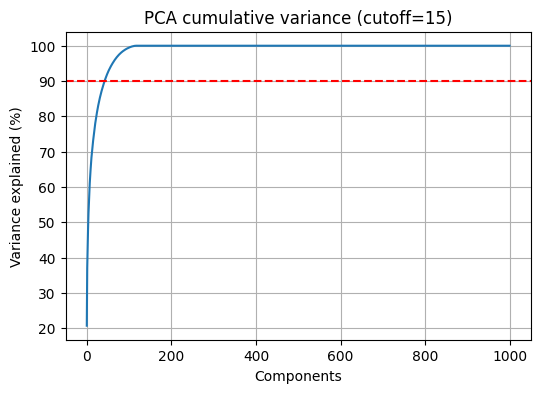


Training SAE on PCA features (all images)...
Epoch  10/60 | loss=0.000974
Epoch  20/60 | loss=0.000993
Epoch  30/60 | loss=0.000748
Epoch  40/60 | loss=0.000678
Epoch  50/60 | loss=0.000657
Epoch  60/60 | loss=0.000658
SAE latent shape: (5900, 100)

Running 5-fold CV on 500 randomly sampled neurons...
  → finished 50/500 neurons
  → finished 100/500 neurons
  → finished 150/500 neurons
  → finished 200/500 neurons
  → finished 250/500 neurons
  → finished 300/500 neurons
  → finished 350/500 neurons
  → finished 400/500 neurons
  → finished 450/500 neurons
  → finished 500/500 neurons

=== 5-Fold Crossvalidated Brier Scores (Held-out Images) ===
       neuron_idx  Brier_PCA_mean  Brier_PCA_std  Brier_SAE_mean  \
count    500.0000        500.0000       500.0000        500.0000   
mean   19525.8560          0.1984         0.0221          0.2023   
std    11244.4731          0.0262         0.0096          0.0292   
min      207.0000          0.0618         0.0025          0.0732   
25%  

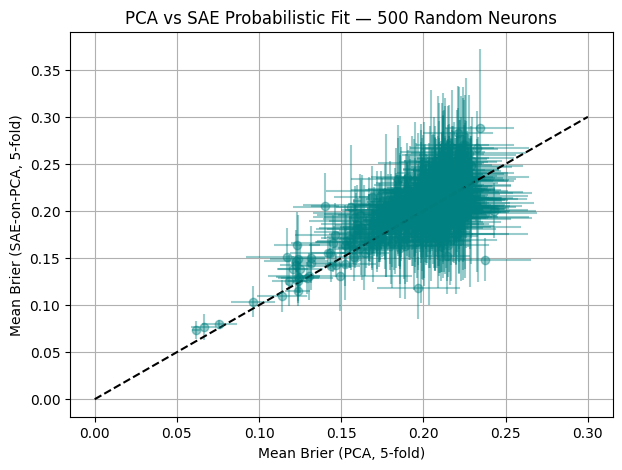

In [7]:
# ================================================================
#   5-FOLD CV on 500 Random Neurons — PCA vs SAE (Brier Score)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, warnings, torch, torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax
from skbio.stats.composition import clr
from torch.utils.data import DataLoader, TensorDataset
from sklearn.exceptions import ConvergenceWarning

# ---------------------------------------------------------------
# Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Helper: Brier
# ---------------------------------------------------------------
def compute_brier(y_true, y_pred, img_ids):
    """Collapse predictions by image, compute mean Brier score."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    return np.mean((agg["p"] - agg["y"]) ** 2)

# ================================================================
# Load Data
# ================================================================
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))           # (118, 1000)
X = softmax(embeddings, axis=1)                 # (118, 1000)
Y_binary = (dat > 0).astype(int)                # (neurons, samples)

n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
assert n_samples == n_images * n_trials
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ================================================================
# CLR + PCA + SAE setup
# ================================================================
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

pca_full = PCA()
pca_full.fit(X_trials_clr)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
n_components_90 = 15
print(f"PCA: {n_components_90} comps explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
X_pca_full = pca.fit_transform(X_trials_clr)

plt.figure(figsize=(6, 4))
plt.plot(cum_var * 100)
plt.axhline(90, color="r", linestyle="--")
plt.title(f"PCA cumulative variance (cutoff={n_components_90})")
plt.xlabel("Components"); plt.ylabel("Variance explained (%)")
plt.grid(True); plt.show()

# ================================================================
# Sparse Autoencoder on PCA Features
# ================================================================
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs + 1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE on PCA features (all images)...")
sae_model, sae_scaler = train_sae(X_pca_full)
Z_full = encode(sae_model, sae_scaler, X_pca_full)
print(f"SAE latent shape: {Z_full.shape}")

# ================================================================
# 5-Fold Crossvalidation on 500 Random Neurons
# ================================================================
num_neurons_to_sample = 500
sampled_neurons = rng.choice(np.arange(n_neurons), size=num_neurons_to_sample, replace=False)
print(f"\nRunning 5-fold CV on {num_neurons_to_sample} randomly sampled neurons...")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(n_images)))

records = []
for i, nid in enumerate(sampled_neurons, 1):
    y_all = Y_binary[nid]
    b_pca_folds, b_sae_folds = [], []

    for train_img_idx, test_img_idx in folds:
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full, test_img_idx)
        Xp_train, Xp_test = X_pca_full[train_mask], X_pca_full[test_mask]
        Z_train, Z_test   = Z_full[train_mask], Z_full[test_mask]
        y_train, y_test   = y_all[train_mask], y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        log_pca = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_pca.fit(Xp_train, y_train)
        y_pred_pca = log_pca.predict_proba(Xp_test)[:, 1]
        b_pca = compute_brier(y_test, y_pred_pca, test_img_ids)
        b_pca_folds.append(b_pca)

        log_sae = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        b_sae = compute_brier(y_test, y_pred_sae, test_img_ids)
        b_sae_folds.append(b_sae)

    records.append({
        "neuron_idx": nid,
        "Brier_PCA_mean": np.nanmean(b_pca_folds),
        "Brier_PCA_std": np.nanstd(b_pca_folds),
        "Brier_SAE_mean": np.nanmean(b_sae_folds),
        "Brier_SAE_std": np.nanstd(b_sae_folds),
        "delta_Brier_mean": np.nanmean(np.array(b_sae_folds) - np.array(b_pca_folds))
    })
    if i % 50 == 0:
        print(f"  → finished {i}/{num_neurons_to_sample} neurons")

df_cv = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Brier Scores (Held-out Images) ===")
print(df_cv.describe().round(4))

# Optionally save
df_cv.to_csv("brier_results_500neurons.csv", index=False)
print("\nSaved → brier_results_500neurons.csv")

# ================================================================
# Visualization
# ================================================================
plt.figure(figsize=(7,5))
plt.errorbar(df_cv["Brier_PCA_mean"], df_cv["Brier_SAE_mean"],
             xerr=df_cv["Brier_PCA_std"], yerr=df_cv["Brier_SAE_std"],
             fmt='o', alpha=0.4, color='teal')
plt.plot([0,0.3],[0,0.3],'k--')
plt.xlabel("Mean Brier (PCA, 5-fold)")
plt.ylabel("Mean Brier (SAE-on-PCA, 5-fold)")
plt.title("PCA vs SAE Probabilistic Fit — 500 Random Neurons")
plt.grid(True)
plt.show()


In [ ]:
np.sqrt(0.06)

np.float64(0.2449489742783178)

(array([  3.,   0.,   3.,   6.,   9.,  12.,  33.,  54., 113., 121.,  79.,
         41.,  14.,  10.,   2.]),
 array([0.07322471, 0.08755461, 0.10188451, 0.11621441, 0.13054431,
        0.14487421, 0.1592041 , 0.173534  , 0.1878639 , 0.2021938 ,
        0.2165237 , 0.2308536 , 0.2451835 , 0.2595134 , 0.2738433 ,
        0.28817319]),
 <BarContainer object of 15 artists>)

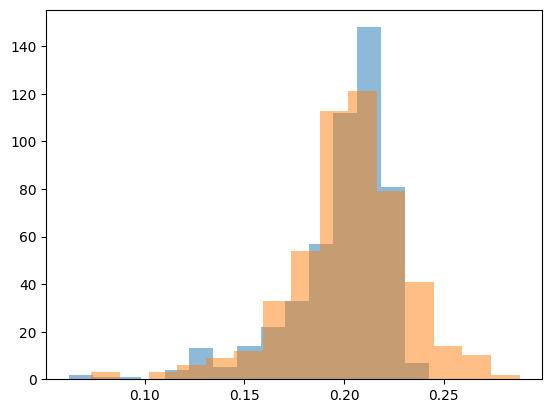

In [13]:
import matplotlib.pyplot as plt

plt.hist(df_cv['Brier_PCA_mean'],bins=15,alpha=0.5)
plt.hist(df_cv['Brier_SAE_mean'],bins=15,alpha=0.5)

In [18]:
df_cv["Brier_SAE_mean"].mean(),df_cv["Brier_PCA_mean"].mean()

(np.float64(0.20231241512367382), np.float64(0.19842650861591554))

In [14]:
import numpy as np
from scipy.stats import wilcoxon

stat, p = wilcoxon(df_cv["Brier_SAE_mean"], df_cv["Brier_PCA_mean"],alternative='less')
print(f"Wilcoxon p={p:.4f}, median Δ={np.median(df_cv['Brier_SAE_mean'] - df_cv['Brier_PCA_mean']):.4f}")


Wilcoxon p=1.0000, median Δ=0.0033


In [15]:
from scipy.stats import ks_2samp
stat, p = ks_2samp(df_cv["Brier_PCA_mean"], df_cv["Brier_SAE_mean"])
print(f"KS test p={p:.4g}")


KS test p=0.0004212


In [16]:
np.corrcoef(df_cv["Brier_SAE_mean"], df_cv["Brier_PCA_mean"])

array([[1.        , 0.75638105],
       [0.75638105, 1.        ]])